**Zespół numer 11**: Katarzyna Zaleska, Katarzyna Witowska, Izabela Lengiewicz

**Implementowana funkcja**: `gc_content`

## **Wprowadzenie**

W ramach tego etapu projektu stworzona została funkcja gc_content w pliku `src/gc_content.rs`.

Funkcję tę można wykorzystywać w zapytaniach SQL w silniku `DataFusion`. Jej zadaniem jest obliczenie zawartości GC w sekwencjach DNA – czyli procentowego udziału nukleotydów G (guanina) i C (cytozyna) w stosunku do całkowitej liczby znaków w sekwencji (z pominięciem znaków N, które oznaczają nieokreślony nukleotyd).  Sekwencje są najpierw przekształcane do postaci bajtowej, a następnie zliczane są odpowiednie znaki. Jeśli sekwencja zawiera wyłącznie N, funkcja zwraca 0. Całość rejestrowana jest jako UDF (user-defined function) typu Skalar (pobiera wiersz danych i zwraca pojedynczą wartość), dzięki czemu można jej używać w SQL pod nazwą gc_content.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import time

import polars_bio as pb

INFO:polars_bio:Creating BioSessionContext


### **Przykład działania funkcji**

In [4]:
df = pb.read_fastq("/home/kzaleskaa/Projects/tbd-zespol-11/polars-bio/tests/data/example.fastq").collect()

INFO:polars_bio:Table: example registered for path: /home/kzaleskaa/Projects/tbd-zespol-11/polars-bio/tests/data/example.fastq


0rows [00:00, ?rows/s]

In [5]:
pb.sql("show tables").collect()

0rows [00:00, ?rows/s]

table_catalog,table_schema,table_name,table_type
str,str,str,str
"""datafusion""","""public""","""example""","""BASE TABLE"""
"""datafusion""","""information_schema""","""tables""","""VIEW"""
"""datafusion""","""information_schema""","""views""","""VIEW"""
"""datafusion""","""information_schema""","""columns""","""VIEW"""
"""datafusion""","""information_schema""","""df_settings""","""VIEW"""
"""datafusion""","""information_schema""","""schemata""","""VIEW"""


In [6]:
pb.sql("select * from example").collect()

0rows [00:00, ?rows/s]

name,description,sequence,quality_scores
str,str,str,str
"""SRR9130495.1""","""D00236:723:HG32CBCX2:1:1108:13…","""NCAATACAAAAGCAATATGGGAGAAGCTAC…","""#4BDFDFFHGHGGJJJHIIIIGGIIJGJJG…"
"""SRR9130495.2""","""D00236:723:HG32CBCX2:1:1108:14…","""NGTCAAAGATAAGATCAAAAGGCACTGGCT…","""#1=DDDDD>DHFH@EFHHGHGGFGIIIGIG…"
"""SRR9130495.3""","""D00236:723:HG32CBCX2:1:1108:17…","""GTTTTCCTCTGGTTATTTCTAGGTACACTG…","""@@@DDDFFHHHFHBHIIGJIJIIJIIIEHG…"
"""SRR9130495.4""","""D00236:723:HG32CBCX2:1:1108:16…","""GGGAGGCGCCCCGACCGGCCAGGGCGTGAG…","""CCCFFFFFHHHHGHIIIGIIJIIIJJGHFF…"
"""SRR9130495.5""","""D00236:723:HG32CBCX2:1:1108:16…","""CACTCCGCCACTACAGCAGTCCCCCAGTGT…","""++=A1A:1ADA<;FFDC?;CG<F;::1CFI…"
…,…,…,…
"""SRR9130495.196""","""D00236:723:HG32CBCX2:1:1108:99…","""TCTTGTGAAGAAGATGCTGTTGGAAGCCTC…","""CCCFFFFFHGDFGIIJJIJJIGGJJIIJJI…"
"""SRR9130495.197""","""D00236:723:HG32CBCX2:1:1108:99…","""TGGGGCTGTGAACCGAAGTCTGCTCCTTTG…","""@BCFFDAFHHHHHIIIIHIIJIIJIIJJJI…"
"""SRR9130495.198""","""D00236:723:HG32CBCX2:1:1108:10…","""ATGTGCTCAAAGGCTGGGTGGACCTTACCT…","""@CCFFFDDFFBHDHIIIBFEGFGHGHGDFH…"


In [7]:
start = time.time()
df_results = pb.sql("select sequence, gc_content(sequence) as gc from example").collect()
end = time.time()

print(f"Query execution time: {end - start:.2f} seconds")

0rows [00:00, ?rows/s]

Query execution time: 0.03 seconds


### **Wizualizacja wyników**

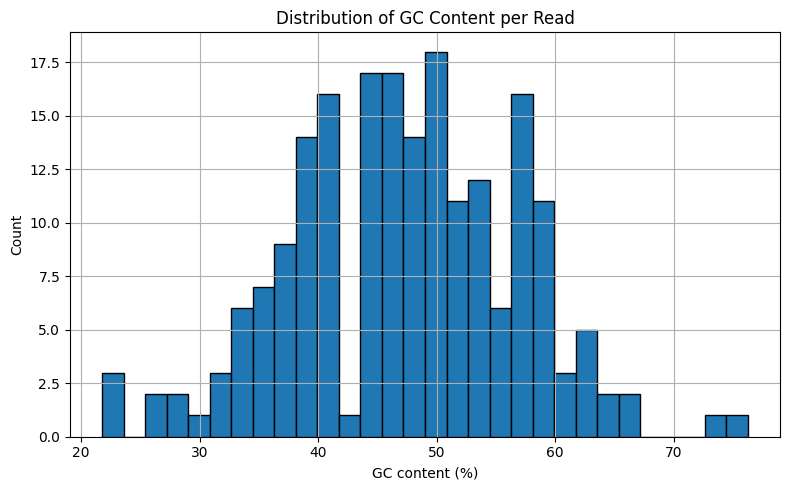

In [8]:
df_results = df_results.to_pandas()
plt.figure(figsize=(8, 5))
df_results['gc'].hist(bins=30, edgecolor='black')
plt.xlabel('GC content (%)')
plt.ylabel('Count')
plt.title('Distribution of GC Content per Read')
plt.grid(True)
plt.tight_layout()
plt.show()

### **Porównanie z wzorcową implementacją (mały plik)**

Podczas analizy zauważyłyśmy nieścisłość w implementacji wzorcowej funkcji GC content. Fragment kodu odpowiedzialny za odfiltrowanie znaków N z sekwencji nie działał poprawnie. Problem wynikał z użycia operatora logicznego or (`||`) zamiast and (`&&`), co skutkowało brakiem rzeczywistej filtracji.
Z powodu tego błędu znaki N (oznaczające nieznane nukleotydy) były nadal uwzględniane w obliczeniach zawartości GC, co mogło zaniżać lub zawyżać wyniki.

Zarówno w naszej implementacji, jak i w poprawionej wersji wzorcowej, zastosowano spójną logikę, co zapewnia skuteczne filtrowanie znaków `N` lub `n`.

In [9]:
start = time.time()

subprocess.run(
    [
        "fqc",
        "-q",
        "/home/kzaleskaa/Projects/tbd-zespol-11/polars-bio/fastqc-rs/tests/resources/example.fastq"
    ],
    stdout=open("report.json", "w")
)

end = time.time()
print(f"Execution time: {end - start:.5f} seconds")

Execution time: 0.00791 seconds


In [10]:
df_report = pd.read_json("/home/kzaleskaa/Projects/tbd-zespol-11/polars-bio/fastqc-rs/report.json")
df_report.head()

,gc_percent,read_length
0,40.789474,101
1,36.046513,101
2,36.363636,101
3,76.237625,101
4,54.455444,101


In [11]:
df_compare = pd.DataFrame({
    "gc_fqc": df_report["gc_percent"],
    "gc_custom": df_results["gc"]
})
df_compare["abs_diff"] = (df_compare["gc_fqc"] - df_compare["gc_custom"]).abs()

In [12]:
mean_diff = df_compare["abs_diff"].mean()
print(f"Mean absolute GC% difference: {mean_diff:.4f}%")

Mean absolute GC% difference: 0.0000%


### **Porównanie z wzorcową implementacją (duży plik)**

In [2]:
df_big = pb.read_fastq("/home/kzaleskaa/Projects/tbd-zespol-11/polars-bio/tests/data/gc_content/ERR194147.fastq").collect()

INFO:polars_bio:Table: err194147 registered for path: /home/kzaleskaa/Projects/tbd-zespol-11/polars-bio/tests/data/gc_content/ERR194147.fastq


0rows [00:00, ?rows/s]

In [3]:
pb.sql("show tables").collect()

0rows [00:00, ?rows/s]

table_catalog,table_schema,table_name,table_type
str,str,str,str
"""datafusion""","""public""","""err194147""","""BASE TABLE"""
"""datafusion""","""information_schema""","""tables""","""VIEW"""
"""datafusion""","""information_schema""","""views""","""VIEW"""
"""datafusion""","""information_schema""","""columns""","""VIEW"""
"""datafusion""","""information_schema""","""df_settings""","""VIEW"""
"""datafusion""","""information_schema""","""schemata""","""VIEW"""


In [4]:
start = time.time()
df_results_big = pb.sql("select sequence, gc_content(sequence) as gc from err194147").collect()
end = time.time()

print(f"Query execution time: {end - start:.2f} seconds")

0rows [00:00, ?rows/s]

Query execution time: 97.24 seconds


In [2]:
start = time.time()

subprocess.run(
    [
        "fqc",
        "-q",
        "/home/kzaleskaa/Projects/tbd-zespol-11/polars-bio/tests/data/gc_content/ERR194147.fastq"
    ],
    stdout=open("report_big.json", "w")
)

end = time.time()
print(f"Execution time: {end - start:.5f} seconds")

Execution time: 8.44313 seconds


### **Porównanie czasu wykonania**

Przeprowadzono pomiar czasu wykonania zapytania SQL `gc_content(sequence)` dla dwóch zestawów danych: małego i dużego. Wyniki porównano z implementacją wzorcową.

| Zestaw danych | Nasza implementacja | Wzorcowa implementacja | Różnica |
|---------------|---------------------|-------------------------|---------|
| Mały          | 0.03 s              | 0.00791 s               | ~3.8× wolniej |
| Duży          | 97.24 s             | 8.44 s                  | ~11.5× wolniej |

### **Testy funkcji `gc_content`**

Testy jednostkowe zawarte w klasie `TestSQLGCContent` (plik `tests/test_gc_content.py`) weryfikują poprawność działania funkcji UDF `gc_content`, która oblicza procentową zawartość nukleotydów G i C w sekwencjach DNA.

**Zakres testów:**

- **Poprawność działania zapytania SQL** - sprawdzamy, czy zapytanie `SELECT sequence, gc_content(sequence) AS gc FROM reads` wykonuje się poprawnie na danych FASTQ.

- **Zgodność wymiarów i schematu danych** - weryfikujemy, czy wynikowe dane mają taki sam kształt i kolumny (`sequence`, `gc`) jak dane referencyjne.

- **Typy danych** - sprawdzamy, czy kolumna `sequence` ma typ tekstowy (`object`), a `gc` typ zmiennoprzecinkowy (`float64`).

- **Zgodność wartości GC** - porównujemy obliczone wartości procentowe zawartości GC z oczekiwanymi wynikami zapisanymi w `EXPECTED_SQL_GC_DF`.
